In [9]:
import os
import vtuIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

$$\require{mhchem}$$

# OGS-PHREEQC-Benchmark: $\ce{CO2}$ injection into Opalinus Clay

## Overview
The present numerical work is motivated by the CO2LPIE project (shortened as CL-experiment) [1], which is an in-situ experiment that is being conducted at the Mont Terri
rock laboratory.
In the experiment, carbon dioxide ($\ce{CO2}$) is injected into the Opalinus Clay leading to changes in its hydraulic, mechanical and chemical properties.
In general, these processes are of great interest in the evaluation of barrier integrity.

Two scenarios are considered in this benchmark.
In the first scenario, the pure $\ce{CO2}$ gas induced Calcite dissolution is simulated by OGS6-IPhreeqc and the results are verified with the related PHREEQC example presented by Appelo and Postma [2].
A comprehensive information regarding the computational procedure of OGS6-IPhreeqc can be found in Lu et al. [3].
In the second scenario, the simulation considers a more accurate representation of chemical environments based on the CL Project.
This includes the incorporation of primary minerals typically found in Opalinus Clay and the relevant composition of species present in the pore water.

## Scenario #1: Kinetics of $\ce{CO2}$ induced calcite dissolution

### Problem description

In this case, carbon dioxide ($\ce{CO2}$) gas with a partial pressure $\mathrm{10^{-1.5}}$ $\mathrm{bar}$ is injected into a fluid containing calcite.
The temperature is maintained at 10 $\mathrm{°C}$, the fluid’s pH value is set at 6 and the initial concentration of calcite is 1 $\mathrm{mol\cdot kg^{-1}\cdot water}$ (shortened as $\mathrm{mol/kgw}$).
The dissolution of the $\ce{CO2}$ gas in water together with the calcite dissolution pathways can be described with the following reactions (Plummer et al. [4], Appelo and Postma [2]).

$$ \ce{CO2_{(g)} + H2O -> H2CO3^{\ast}} $$
$$ \ce{CaCO3 + H+ <=> Ca^2+ + HCO3-} $$
$$ \ce{CaCO3 + H2CO3^{\ast} <=> Ca^2+ + 2HCO3-} $$
$$ \ce{CaCO3 + H2O <=> Ca^2+ + HCO3- + OH-} $$

Two kinetic rates are adopted to describe the calcite dissolution.
The first approach involves a simplified rate calculation derived directly from the current concentration of calcium,
employing the following formula: $\text{rate} = 10^{-6.91} - 10^{-1.52} * (c_{\ce{Ca}})^2$, with $c_{\ce{Ca}}$ in $\mathrm{mol/kgw}$.
And another one is the well known PWP rate, which is proposed by Plummer, Wigley and Parkhurst (denoted further as “PWP”) in 1978 for calcite dissolution based on three dissolution reactions [4].
The formulae of the PWP approach is available to be found in the PHREEQC database e.g. phreeqc.dat.
In the numerical experiment, the total simulation time is 30 000 $\mathrm{s}$.
Details about the case study is described in the example 5.9 from Appelo and Postma [2].
The related PHREEQC script is available online to be found [5].

### Model and results

A simple 1D line-element model with one element is constructed in this work.
The coupled Hydraulic-Chemical (HC) Process is adopted for the OGS6-IPhreeqc simulation.
To match the PHREEQC example, the advection and diffusion have been set to zero in the modelling.
The initial conditions and chemical parameters are provided as outlined in the associated example.
The Fig. 1 depicts the comparison between the computed results obtained from the OGS6-IPhreeqc model and the results derived from PHREEQC, which shows a very
good agreement with each other.
Preparation of the simulation and results evaluation are presented in what follows.

### 1) Solve the numerical model

In [3]:
out_dir = os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# simple
prj_name = "calcite_simple.prj"

t0 = time.time()
print(">>> OGS started execution ... <<<")

! ogs {prj_name} -o {out_dir} > {out_dir}/out_simple.txt

tf = time.time()
print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")

# check if the simulation runs successfully
check_file = os.path.isfile(f"{out_dir}/calcite_simple_ts_43_t_30000.000000.vtu")
if check_file:
    print("OGS simulation for the scenario simple case runs successfully")
else:
    raise Exception("OGS simulation failed.")

# pwp
prj_name = "calcite_pwp.prj"

t0 = time.time()
print(">>> OGS started execution ... <<<")

! ogs {prj_name} -o {out_dir} > {out_dir}/out_pwp.txt

tf = time.time()
print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")

# check if the simulation runs successfully
check_file = os.path.isfile(f"{out_dir}/calcite_pwp_ts_43_t_30000.000000.vtu")
if check_file:
    print("OGS simulation for the scenario PWP case runs successfully")
else:
    raise Exception("OGS simulation failed.")

>>> OGS started execution ... <<<
/bin/bash: ogs: command not found
>>> OGS terminated execution  <<< Elapsed time:  0.13  s.


Exception: OGS simulation failed.

In [60]:
### Read OGS-6 simulation results

# simple
# pvdfile_simple = vtuIO.PVDIO("./sce1_results_simple/calcite_simple.pvd", dim=1)
pvdfile_simple = vtuIO.PVDIO(f"{out_dir}/calcite_simple.pvd", dim=1)

# pwp
# pvdfile_pwp = vtuIO.PVDIO("./sce1_results_pwp/calcite_pwp.pvd", dim=1)
pvdfile_pwp = vtuIO.PVDIO(f"{out_dir}/calcite_pwp.pvd", dim=1)

# Read PHREEQC results

# simple
phreeqc_result_df_simple = pd.read_csv(
    "./PHREEQC_results_simple.txt", sep="\s+", header=0, skipinitialspace=True
)

# pwp
phreeqc_result_df_pwp = pd.read_csv(
    "./PHREEQC_results_PWP.txt", sep="\s+", header=0, skipinitialspace=True
)

### visulalization
# results at point [0, 0, 0] are selected for display
point = {"pt0": (0.0, 0.0, 0.0)}

# plot
fig1 = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

## results of 'Ca'
# OGS-6
ax.plot(
    pvdfile_simple.timesteps,
    pvdfile_simple.read_time_series("Ca", point)["pt0"] * 1e3,
    c="k",
    linestyle="--",
    label="Simple " + "OGS-6",
)
ax.plot(
    pvdfile_pwp.timesteps,
    pvdfile_pwp.read_time_series("Ca", point)["pt0"] * 1e3,
    c="k",
    label="PWP " + f"OGS-6",
)
# PHREEQC
ax.scatter(
    phreeqc_result_df_simple.loc[:, "x"] * 1e3,
    phreeqc_result_df_simple.loc[:, "Ca"],
    c="r",
    s=80,
    marker="x",
    label="Simple " + f"PHREEQC",
)
ax.scatter(
    phreeqc_result_df_pwp.loc[:, "x"] * 1e3,
    phreeqc_result_df_pwp.loc[:, "Ca"],
    c="b",
    s=80,
    marker="x",
    label="PWP " + f"PHREEQC",
)
ax.set_xlim([0, 3e4])
ax.set_ylim([0, 4])
ax.set_ylabel("Ca+ [mmol/kgw]")
ax.set_xlabel("Time [s]")
ann = ax.annotate(
    "Ca+",
    xy=(5000, 0.7),
    xycoords="data",
    va="center",
    ha="center",
    bbox=dict(boxstyle="round", fc="w"),
    fontsize=16,
)
ax.legend(loc="upper left", fontsize=10)

## results of 'pH'
ax2 = ax.twinx()
# OGS-6
ax2.plot(
    pvdfile_simple.timesteps,
    -np.log10(pvdfile_simple.read_time_series("H", point)["pt0"]),
    c="k",
    linestyle="--",
    label="Simple " + "OGS-6",
)
ax2.plot(
    pvdfile_pwp.timesteps,
    -np.log10(pvdfile_pwp.read_time_series("H", point)["pt0"]),
    c="k",
    label="PWP " + f"OGS-6",
)
# PHREEQC
ax2.scatter(
    phreeqc_result_df_simple.loc[:, "x"] * 1e3,
    phreeqc_result_df_simple.loc[:, "pH"],
    c="r",
    s=80,
    marker="x",
    label="simple " + f"PHREEQC",
)
ax2.scatter(
    phreeqc_result_df_pwp.loc[:, "x"] * 1e3,
    phreeqc_result_df_pwp.loc[:, "pH"],
    c="b",
    s=80,
    marker="x",
    label="PWP " + f"PHREEQC",
)
ax2.set_xlim([0, 3e4])
ax2.set_ylim([4, 7.5])
ax2.set_ylabel("pH")
ax2.set_xlabel("Time [s]")
ann1 = ax2.annotate(
    "pH",
    xy=(5000, 6.4),
    xycoords="data",
    va="center",
    ha="center",
    bbox=dict(boxstyle="round", fc="w"),
    fontsize=16,
)

slight changes of interpolated values if defaults are/were used.


RuntimeError: File not found: _out/calcite_simple.pvd

Fig. 1: pH and calcium increase with kinetic dissolution of Calcite.

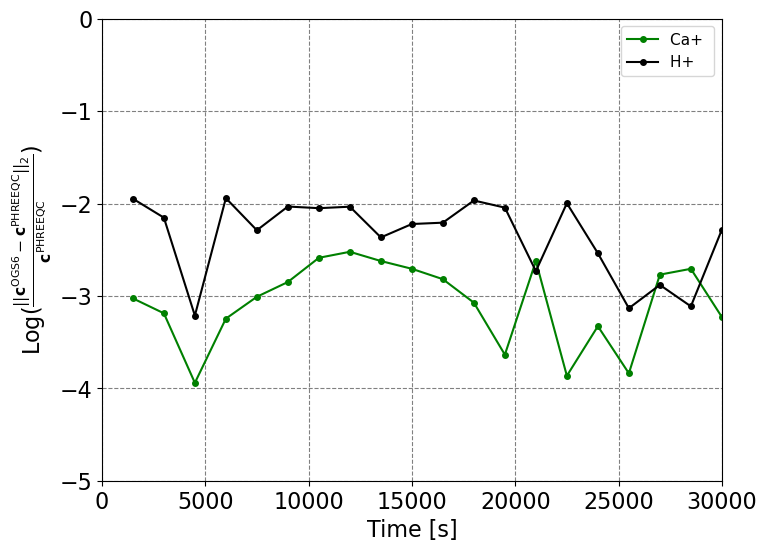

In [45]:
## L2 difference

# OGS-6 results for comparision
OGS6_pwp_ca = (
    np.delete((pvdfile_pwp.read_time_series("Ca", point)["pt0"]), np.arange(0, 24, 1))
    * 1e3
)
OGS6_pwp_H = np.delete(
    pvdfile_pwp.read_time_series("H", point)["pt0"], np.arange(0, 24, 1)
)

# plot
fig1 = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.plot(
    phreeqc_result_df_pwp.loc[:, "x"] * 1e3,
    np.log10(
        ((OGS6_pwp_ca - phreeqc_result_df_pwp.loc[1:, "Ca"]) ** 2) ** 0.5
        / phreeqc_result_df_pwp.loc[:, "Ca"]
    ),
    c="g",
    marker="o",
    markersize=4,
    label="Ca+ ",
)
ax.plot(
    phreeqc_result_df_pwp.loc[:, "x"] * 1e3,
    np.log10(
        ((OGS6_pwp_H - 10 ** (-phreeqc_result_df_pwp.loc[1:, "pH"])) ** 2) ** 0.5
        / 10 ** (-phreeqc_result_df_pwp.loc[:, "pH"])
    ),
    c="k",
    marker="o",
    markersize=4,
    label="H+ ",
)
ax.set_xlim([1500, 3e4])
ax.set_xticks(np.arange(0, 30001, 5000))
ax.set_ylim([-5, 0])
ax.set_xlabel("Time [s]")
ax.set_ylabel(
    r"Log($\frac{|| \mathbf{c}^\mathrm{OGS6} - \mathbf{c}^{\mathrm{PHREEQC}}||_{2}}{\mathbf{c}^{\mathrm{PHREEQC}}}$)"
)
ax.grid(color="gray", linestyle="dashed")
ax.legend(loc="best", fontsize=11)

Fig. 2:  L2 relative difference norm between the obtained results from OGS-6 and PHREEQC for the scenario with the PWP rate.

## Scenario #2: Modelling of the $\ce{CO2}$ injection into Opalinus Clay

### Model description

The identical 1D line-element model as in scenario #1 is used in the OGS6-IPhreeqc simulation.
In the model, the initial porosity is set to 0.15. Similarly to the scenario #1, hydraulic advection and diffusion are excluded from the simulation.
In this case, chemical environments based on the CL-experiment are considered.
For the porous medium in the OGS-6 model, in terms of the solid component, the following mineral composition is assumed in this work: 36% illite, 24% kaolinite, 7.5% calcite and 2.5% dolomite-dis (namely sedimentary (disordered) dolomite).
The remaining 30% of the mineral is mostly quartz and is not considered in this simulation scenario.
A more detailed description of the mineral composition of Opalinus Clay can be found in the work of Thury [6].
In OGS6-IPhreeqc, the molar amount of each reactive solid component per kilogram of water ${b_m}$ [$\mathrm{mol/kgw}$] is calculated by

$$ {b_m} = \frac{\phi_m}{\rho^{l}\phi V_m},$$

where $\mathrm{\phi_m}$ is the volume fraction of the corresponding mineral ${m}$.
The $\mathrm{\rho^{l}}$ is the density of the fluid in $\mathrm{kg/m^3}$.
The $\mathrm{\phi}$ denotes the porosity of the porous medium.
And the ${V_m}$ is the molar volume of the corresponding mineral ${m}$ in $\mathrm{m^3/mol}$.
Details of the equation description can be found in Lu et al. [3].
In the simulation, the used parameters of the Opalinus Clay minerals are listed in table 1.

During the simulation, a constant carbon dioxide ($\ce{CO2}$) gas partial pressure of $10^{1.5}$ $\mathrm{bar}$ is applied to the model domain, same as in the equilibrium phase.
Notice in this scenario, the $\ce{CO2}$ partial pressure is much higher than it in scenario #1.
Consequently, the dissolved $\ce{CO2}$ results in an alteration in the acidity of the pore water and leads to the different chemical reactions of each mineral.
The related reaction formulae are described in the PHREEQC database `llnl.dat`.
The adopted kinetic dissolution rate of each mineral are referenced from the transition state theory-based reaction mechanism following the work by Palandri and Kharaka [7]. The general equation formula reads

$${{\text{Rate}_\mathrm{mineral}}} = [ k_{\mathrm{acid_{mineral}}}^\mathrm{298.15K}{a_\mathrm{H^{+}}} + k_{\mathrm{neutral_{mineral}}}^\mathrm{298.15K} + k_{\mathrm{base_{mineral}}}^\mathrm{298.15K}{a_\mathrm{{H_{2}CO_{3}}^{*}}} ](1 - \mathrm{SR_{mineral}}),
\label{eq:transition_state}$$ with
$$\mathrm{SR_{mineral}} = \frac{\mathrm{IAP_{mineral}}}{K_\mathrm{eq,mineral}},$$

where $a$ denotes the activity of the ion, and $\mathrm{SR}$ is the abbreviation for the saturation ratio of a phase, which describes the ion activity product $\mathrm{IAP}$ divided by equilibrium constant $K_\mathrm{eq}$.
In the simulation, the main species composition within the Opalinus Clay pore water are considered and the corresponding values are listed in table 2, following the
work of Wersin et al. [8].


| Minerals     |    Volume fraction [-]  | Molar volume in [$\mathrm{m^3/mol}$] | Molality in [$\mathrm{mol/kgw}$]      |
|:--------------:|:-------------------------:|:--------------------------------------:|:---------------------------------------:|
| Calcite      | 0.06375                 | 3.6934e-5                            | 11.507                                |
| Dolomite-dis | 0.02125                 | 6.439e-5                             | 2.2                                   |
| Illite       | 0.306                   | 1.4148e-4                            | 14.419                                |
| Kaolinite    | 0.204                   | 9.935e-5                             | 13.689                                |

Table 1: Parameter of the Opalinus Clay minerals used in the modeling


| Species | Value in [mol/kgw]      |
|:---------:|:-------------------------:|
| C(4)    | $3.89 \times 10^{-3}$   |
| Ca      | $1.89 \times 10^{-2}$   |
| Mg      | $2.197 \times 10^{-2}$  |
| Cl      | $3.2667 \times 10^{-1}$ |
| K       | $1.92 \times 10^{-3}$   |
| Na      | $2.8067 \times 10^{-1}$ |
| S(6)    | $1.679 \times 10^{-2}$  |
| Al      | $2.295 \times 10^{-10}$ |
| Si      | $1.7 \times 10^{-5}$    |
| Sr      | $4.6 \times 10^{-5}$    |

Table 2: concentration of the species in the Opalinus Clay pore water

For verification purposes, a corresponding PHREEQC model was constructed with identical parameter settings.

### Results

On the Fig. 3 a) the evolution of calcium and magnesium molality during the $\ce{CO2}$ injection computed from the OGS-6 and PHREEQC model is shown.
And the Fig. 3 b) displays the L2 relative difference norm between the results computed by the two software.
The results of the two software programs match perfectly.
On the Fig. 4 the evolution of the dissoluted molality of each minerals during the simulation is illustrated.
Only calcite and dolomite have been partially dissolved due to $\ce{CO2}$ injection.
In contrast, clay minerals, the illite and kaolinite were hardly affected.
The kinetic dissolution rate of calcite and dolomite is mostly controlled by their saturation ratio states.
When the SR value of calcite and dolomite reaches 1, the dissolution process of the correspondences is stopped.

**Note:**
The scenario #2 is not directly calculated in the notebook due to the lack of the large input file `llnl.dat` database in the commit. Also the post-processing of the scenario #2 is similar to which is showed in the scenario #1.

![Figure 3](figures/results_cl_comparision_sce2.png)
Fig. 3: a) evolution of the calcium and magnesium molality during the $\ce{CO2}$ injection; b) L2 relative difference norm between the results computed by OGS-6 and PHREEQC.

![Figure 4](figures/results_disso_SR.png)
Fig. 4: Evolution of the dissoluted minearals molality and the related saturation ratio of calcite and dolomite over the time.

## Literature

[1] BGR, CO2LPIE project, 2023. URL: [https://www.bgr.bund.de/DE/Themen/Endlagerung/Projekte/Wirtsgesteine_geotechnische_Barrieren/laufend/Nur-Deutsch/mont_terri_experimente.html?nn=1542156](https://www.bgr.bund.de/DE/Themen/Endlagerung/Projekte/Wirtsgesteine_geotechnische_Barrieren/laufend/Nur-Deutsch/mont_terri_experimente.html?nn=1542156).

[2] Appelo, C. A. J. and Postma, D. (2004). Geochemistry, groundwater and pollution. CRC press.

[3] Lu, R., Nagel, T., Poonoosamy, J., Naumov, D., Fischer, T., Montoya, V., Kolditz, O., and Shao, H.
(2022). A new operator-splitting finite element scheme for reactive transport modeling in saturated porous
media. Computers and Geosciences, 163(April 2021):105106. URL: https://doi.org/10.1016/j.cageo.2022.105106.

[4] Plummer, L. N., Wigley, T. M., and Parkhurst, D. L. (1978). KINETICS OF CALCITE DISSOLUTION
IN CO2-WATER SYSTEMS AT 5 degree TO 60 degree C AND 0. 0 TO 1. 0 ATM CO2.

[5] Appelo, C. A. J. and Postma, D. (2023). Example 5.9: Kinetic dissolution of calcite. URL: https://www.hydrochemistry.eu/a&p/5/ex_5_9.phr.

[6] Thury, M. (2002). The characteristics of the Opalinus Clay investigated in the Mont Terri underground
rock laboratory in Switzerland. doi:10.1016/S1631-0705(02)01372-5.

[7] Palandri, J. L. and Kharaka, Y. K. (2004). A compilation of rate parameters of water-mineral interaction
kinetics for application to geochemical modeling.

[8] Wersin, P., Mazurek, M., and Gimmi, T. (2022). Porewater chemistry of Opalinus Clay revisited:
Findings from 25 years of data collection at the Mont Terri Rock Laboratory. Applied Geochemistry,
138(November 2021):105234. URL: https://doi.org/10.1016/j.apgeochem.2022.105234.
